In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tqdm
import seaborn as sns
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from patsy import dmatrix
from scipy.interpolate import interp1d
from scipy.stats import norm
from matplotlib import cm
from wordcloud import WordCloud

In [3]:
data5 = pd.read_csv('dataset/data6.csv', header=0)
data5.head(2)

,GenericName,SideeffectTerm,FrequencyRatingValue,dg_smile_unif,adr_similar,Macc,pubchem,Morgan,Rtoplo,pharmfp
0,alfentanil,asthenia,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,alfentanil,movement disorder,4,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0540540540540...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# 描述性分析

## 药物的adr数量分布

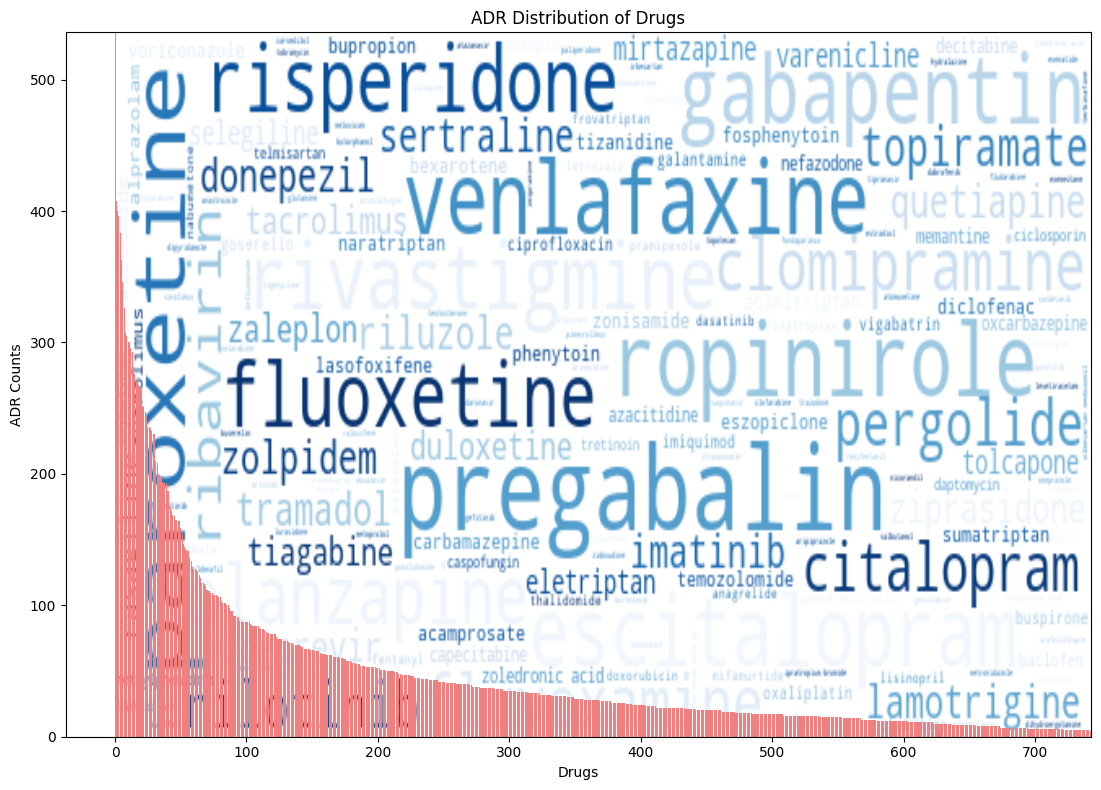

In [16]:
drug_counts = pd.value_counts(data5.GenericName)
# 假设 data5.GenericName 是一个包含药物名的Series或DataFrame列
# 创建一个新的图形
plt.figure(figsize=(14, 8))

# 创建一个词云对象
wordcloud = WordCloud(width=600, height=300, background_color='white', colormap='Blues_r', max_font_size=50).generate_from_frequencies(drug_counts)

# 绘制词云
plt.imshow(wordcloud, interpolation='bilinear', extent=[0, len(drug_counts), 0, max(drug_counts)])

# 绘制柱状图
plt.bar(range(len(drug_counts)), drug_counts, color='lightcoral')

# 添加标题和标签
plt.title('ADR Distribution of Drugs')
plt.xlabel('Drugs')
plt.ylabel('ADR Counts')

# 旋转x轴标签，以避免重叠
# plt.xticks(range(len(drug_counts)), rotation=45, ha='right')

# 显示图形
plt.tight_layout()
plt.savefig("./result/图/figure1_1.pdf", format="pdf", bbox_inches="tight", dpi=600)
plt.show()

## adr的药物的数量分布

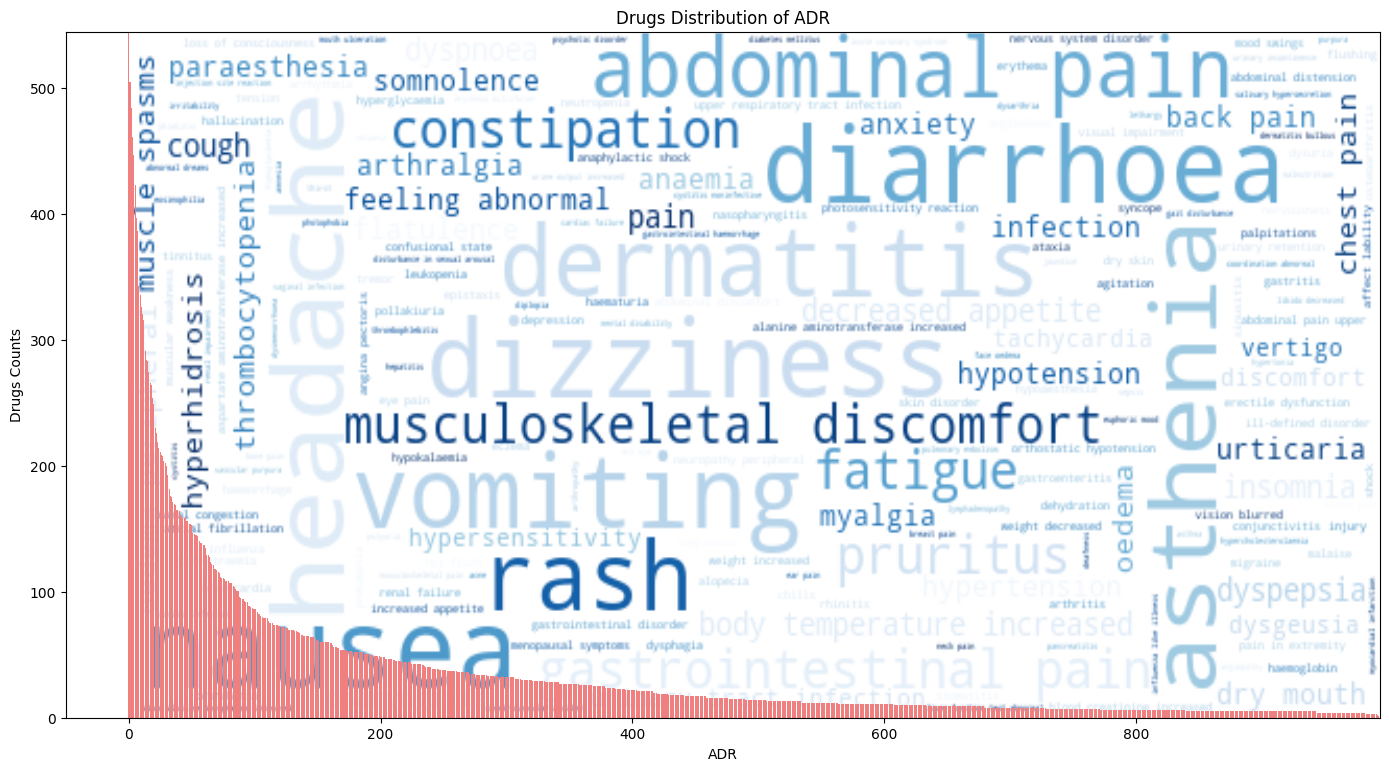

In [15]:
# 假设 data5.GenericName 是一个包含药物名的Series或DataFrame列
adr_counts = pd.value_counts(data5.SideeffectTerm)

# 创建一个新的图形
plt.figure(figsize=(14, 8))

# # 自定义颜色映射函数
# def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
#     return f'hsl(207, 100%, {int(60 + font_size * 1)}%)'  # 调整亮度和饱和度

# 创建一个词云对象，并将词频映射到颜色上
wordcloud = WordCloud(width=600, height=300, background_color='white', colormap='Blues_r', max_font_size=50).generate_from_frequencies(adr_counts)

# 绘制词云
plt.imshow(wordcloud, interpolation='bilinear', extent=[0, len(adr_counts), 0, max(adr_counts)])

# 绘制柱状图
plt.bar(range(len(adr_counts)), adr_counts, color='lightcoral')

# 添加标题和标签
plt.title('Drugs Distribution of ADR')
plt.xlabel('ADR')
plt.ylabel('Drugs Counts')

# 显示图形
plt.tight_layout()
plt.savefig("./result/图/figure1_2.pdf", format="pdf", bbox_inches="tight", dpi=600)
plt.show()

## 具有相同adr的药物的相似性，或者具有相同药物的adr的相似性

In [7]:
#相似性函数,计算jaccord系数相似性
def calculate_tanimoto_similarity_matrix(list1, list2): #list1是一个fp，而list2是一个fp列表
    #删除list2中全部元素为0的子列表
    index = [not all(np.array(i) == 0) for i in list2]
    list2 = list(np.array(list2)[index])
    if len(list2) == 0:
        return np.zeros(1)
    if all(np.array(list1) == 0): #如果输入的list1需要计算的个体的值的全部元素为0则直接返回0向量
        return np.zeros(len(list2))
    # 将 list1 扩展成与 list2 相同形状的矩阵
    list1_matrix = np.tile(list1, (len(list2), 1))
    # 将 list2 转换为 numpy 数组
    list2_matrix = np.array(list2)
    # 计算 Tanimoto similarity
    intersection_count = np.sum(list1_matrix & list2_matrix, axis=1)
    union_count = np.sum(list1_matrix | list2_matrix, axis=1)
    # 避免除以零的情况，也就是说如果一个药物/adr的特征全部为0，则其与其他所有包括他自己的相似性都设置为0
    similarity = intersection_count / union_count 
    return similarity  #返回的是一个np格式的数据

# 计算余弦相似度
def caculate_cos_sim(fp, fp_list):
    #删除list2中全部元素为0的子列表
    index = [not all(np.array(i) == 0) for i in fp_list]
    fp_list = list(np.array(fp_list)[index])
    if len(fp_list) == 0:
        print('no list for caculated')
        return np.zeros(1)
    if all(np.array(fp) == 0): #如果输入的list1需要计算的个体的值的全部元素为0则直接返回0向量
        return np.zeros(len(fp_list))
    
    _fp = [fp for i in range(len(fp_list))]
    _dot = [np.dot(i,j) for i,j in zip(_fp, fp_list)]
    _norm1 = [np.linalg.norm(i) for i in _fp]
    _norm2 = [np.linalg.norm(i) for i in fp_list]
    # #对于范数为0的向量将分布变为1，分子不变恒等于0
    # _norm1 = [1 if element == 0 else element for element in _norm1]
    # _norm2 = [1 if element == 0 else element for element in _norm2]
    _div = [i*j for i,j in zip(_norm1, _norm2)]
    _result = [i/j for i,j in zip(_dot, _div)]
    return np.array(_result)

In [102]:
fp = [0,0,0,0]
fp_list = [[0,0,0,0]]
caculate_cos_sim(fp, fp_list)[0]

no list for caculated


0.0

### 按照具有相同数量的adr来分层来计算药物之间的fp相似

In [9]:
data5.columns

Index(['GenericName', 'SideeffectTerm', 'FrequencyRatingValue',
       'dg_smile_unif', 'adr_similar', 'Macc', 'pubchem', 'Morgan', 'Rtoplo',
       'pharmfp'],
      dtype='object')

#### 先获取每个药物的adr分布

In [8]:
adr_all = pd.unique(data5.SideeffectTerm.tolist())
print(len(adr_all))
drug_all = data5[['GenericName','dg_smile_unif','Macc','Morgan','Rtoplo', 'pharmfp']].drop_duplicates()
drug_all.shape

994


(743, 6)

In [9]:
drug_all['adr_term'] = drug_all['GenericName'].apply(lambda x : data5[data5['GenericName'] == x].SideeffectTerm.tolist()) #获取每个药物出现的adr
drug_all.head(2)

,GenericName,dg_smile_unif,Macc,Morgan,Rtoplo,pharmfp,adr_term
0,alfentanil,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[asthenia, movement disorder, dyskinesia, tach..."
17,telithromycin,CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[flatulence, diarrhoea, dysgeusia, vertigo, vo..."


In [10]:
drug_all['adr_ont_hot'] = drug_all['adr_term'].apply(lambda x : [1 if i in x else 0 for i in adr_all])
drug_all.head(2)

,GenericName,dg_smile_unif,Macc,Morgan,Rtoplo,pharmfp,adr_term,adr_ont_hot
0,alfentanil,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[asthenia, movement disorder, dyskinesia, tach...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
17,telithromycin,CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O[C@...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[flatulence, diarrhoea, dysgeusia, vertigo, vo...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."


In [50]:
print(drug_all.adr_term[0])
print(drug_all.adr_term.iloc[1])

['asthenia', 'movement disorder', 'dyskinesia', 'tachycardia', 'hypertension', 'vomiting', 'injection site pain', 'bradycardia', 'apnoea', 'dizziness', 'procedural pain', 'nausea', 'fatigue', 'chills', 'euphoric mood', 'hypotension', 'muscle rigidity']
['flatulence', 'diarrhoea', 'dysgeusia', 'vertigo', 'vomiting', 'headache', 'dizziness', 'nausea', 'gastrointestinal pain', 'dyspepsia', 'abdominal pain', 'visual impairment']


In [11]:
drug_adr_pair_all = list(itertools.combinations(drug_all.GenericName, 2))
drug_adr_all = pd.DataFrame(drug_adr_pair_all, columns=['GenericName1', 'GenericName2'])
print(drug_adr_all.shape)
drug_adr_all.head(2)

(275653, 2)


,GenericName1,GenericName2
0,alfentanil,telithromycin
1,alfentanil,simeprevir


In [12]:
#计算药物对之间的共有adr数量
def drug_adr_number(drugs1, drugs2, drug_all): 
    _adr1 = drug_all[drug_all['GenericName'] == drugs1]['adr_ont_hot'].tolist()[0]
    _adr2 = drug_all[drug_all['GenericName'] == drugs2]['adr_ont_hot'].tolist()[0]
    com_adr_number = sum([i & j for i,j in zip(_adr1, _adr2)])
    return com_adr_number

In [13]:
drug_adr_all['com_number'] = drug_adr_all.apply(lambda x : drug_adr_number(x['GenericName1'], x['GenericName2'], drug_all), axis=1)
print(drug_adr_all.shape)
drug_adr_all.head(2)

(275653, 3)


,GenericName1,GenericName2,com_number
0,alfentanil,telithromycin,3
1,alfentanil,simeprevir,3


In [57]:
data5.columns

Index(['GenericName', 'SideeffectTerm', 'FrequencyRatingValue',
       'dg_smile_unif', 'adr_similar', 'Macc', 'pubchem', 'Morgan', 'Rtoplo',
       'pharmfp'],
      dtype='object')

In [31]:
drug_adr_all['com_number'] = drug_adr_all.apply(lambda x: len(set(data5[data5['GenericName'] == x['GenericName1']].SideeffectTerm).intersection(set(data5[data5['GenericName'] == x['GenericName2']].SideeffectTerm))),axis=1)
print(drug_adr_all.shape)
drug_adr_all.head(2)

(275653, 3)


,GenericName1,GenericName2,com_number
0,alfentanil,telithromycin,3
1,alfentanil,simeprevir,3


In [58]:
drug_adr_all[(drug_adr_all['com_number'] > 20) & (drug_adr_all['com_number'] <= 100)].shape

(27258, 3)

In [59]:
drug_adr_all[drug_adr_all['com_number'] <=20].shape

(247474, 3)

In [62]:
drug_all.columns

Index(['GenericName', 'dg_smile_unif', 'Macc', 'Morgan', 'Rtoplo', 'pharmfp',
       'adr_term', 'adr_ont_hot'],
      dtype='object')

##### Joeere-Terpstra检验的代码暂时没找到适用的

需要检查一下相似度的计算公式是否有误等

In [23]:
#计算共有adr数量为com_number_index的药物的相似度基于macc
drug_adr_all['drug_pair_similar_score_macc'] = drug_adr_all.apply(lambda x : calculate_tanimoto_similarity_matrix(eval(drug_all[drug_all['GenericName'] == x['GenericName1']].Macc.iloc[0]), [eval(drug_all[drug_all['GenericName'] == x['GenericName2']].Macc.iloc[0])])[0], axis=1)


In [14]:
# #计算共有adr数量为com_number_index的药物的相似度基于pubchem
# drug_adr_all['drug_pair_similar_score_pubchem'] = drug_adr_all.apply(lambda x : calculate_tanimoto_similarity_matrix(eval(drug_all[drug_all['GenericName'] == x['GenericName1']].pubchem.iloc[0]), [eval(drug_all[drug_all['GenericName'] == x['GenericName2']].pubchem.iloc[0])])[0], axis=1)


In [24]:
#计算共有adr数量为com_number_index的药物的相似度基于morgan
drug_adr_all['drug_pair_similar_score_Morgan'] = drug_adr_all.apply(lambda x : calculate_tanimoto_similarity_matrix(eval(drug_all[drug_all['GenericName'] == x['GenericName1']].Morgan.iloc[0]), [eval(drug_all[drug_all['GenericName'] == x['GenericName2']].Morgan.iloc[0])])[0], axis=1)

In [25]:
#计算共有adr数量为com_number_index的药物的相似度基于Rtoplo
drug_adr_all['drug_pair_similar_score_Rtoplo'] = drug_adr_all.apply(lambda x : calculate_tanimoto_similarity_matrix(eval(drug_all[drug_all['GenericName'] == x['GenericName1']].Rtoplo.iloc[0]), [eval(drug_all[drug_all['GenericName'] == x['GenericName2']].Rtoplo.iloc[0])])[0], axis=1)
print("runtime:20m")

runtime:20m


In [26]:
#计算共有adr数量为com_number_index的药物的相似度基于phar
drug_adr_all['drug_pair_similar_score_pharmfp'] = drug_adr_all.apply(lambda x : caculate_cos_sim(eval(drug_all[drug_all['GenericName'] == x['GenericName1']].pharmfp.iloc[0]), [eval(drug_all[drug_all['GenericName'] == x['GenericName2']].pharmfp.iloc[0])])[0], axis=1)
print("runtime:20m")

no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list for caculated
no list fo

In [56]:
drug_adr_all.head(6)

,GenericName1,GenericName2,com_number,drug_pair_similar_score_macc,drug_pair_similar_score_Morgan,drug_pair_similar_score_Rtoplo,drug_pair_similar_score_pharmfp,group_ny
0,alfentanil,telithromycin,3,0.702381,0.153333,0.857283,0.658350,0
1,alfentanil,simeprevir,3,0.592233,0.130137,0.852539,0.574220,0
2,alfentanil,pentamidine isethionate,3,0.360000,0.105263,0.543933,0.285414,0
3,alfentanil,penicillamine,0,0.187500,0.074074,0.383218,0.195934,0
4,alfentanil,lamivudine,6,0.571429,0.175824,0.745226,0.652202,0
5,alfentanil,atorvastatin,1,0.563218,0.146789,0.826621,0.378501,0


In [76]:
drug_adr_all.GenericName1 == drug_adr_all.GenericName2 #确保了没有药物对是同一个药物

0

In [64]:
drug_adr_all['group_ny'] = drug_adr_all['com_number'].apply(lambda  x: 0 if x <= 0 else 1)

In [65]:
drug_adr_all.group_ny.value_counts()

1    253924
0     21729
Name: group_ny, dtype: int64

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

score_list = ["drug_pair_similar_score_macc",	"drug_pair_similar_score_Morgan",	"drug_pair_similar_score_Rtoplo",	"drug_pair_similar_score_pharmfp"]
for score in score_list:
    group1 = drug_adr_all[drug_adr_all['group_ny'] == 0][score]
    group2 = drug_adr_all[drug_adr_all['group_ny'] == 1][score]
    
    # 计算t检验和Mann-Whitney U检验
    t_stat, t_p = ttest_ind(group1, group2)
    u_stat, u_p = mannwhitneyu(group1, group2)
    print(f"{score}t 统计量及其p值：{round(t_stat,3),round(t_p,3)}")
    print(f"{score}u 统计量及其p值：{round(u_stat,3),round(u_p,3)}")

drug_pair_similar_score_macct 统计量及其p值：(-26.097, 0.0)
drug_pair_similar_score_maccu 统计量及其p值：(2462713101.0, 0.0)
drug_pair_similar_score_Morgant 统计量及其p值：(-12.841, 0.0)
drug_pair_similar_score_Morganu 统计量及其p值：(2599020774.5, 0.0)
drug_pair_similar_score_Rtoplot 统计量及其p值：(-28.802, 0.0)
drug_pair_similar_score_Rtoplou 统计量及其p值：(2475616042.0, 0.0)
drug_pair_similar_score_pharmfpt 统计量及其p值：(-32.835, 0.0)
drug_pair_similar_score_pharmfpu 统计量及其p值：(2385672833.0, 0.0)


In [32]:
drug_adr_all[drug_adr_all['group_ny'] == 0][score_list]

,drug_pair_similar_score_macc,drug_pair_similar_score_Morgan,drug_pair_similar_score_Rtoplo,drug_pair_similar_score_pharmfp
3,0.187500,0.074074,0.383218,0.195934
8,0.181818,0.086957,0.224004,0.058073
10,0.430233,0.092784,0.589055,0.624344
30,0.320513,0.133333,0.338596,0.472867
34,0.202703,0.166667,0.224355,0.481760
...,...,...,...,...
275391,0.478873,0.130435,0.920666,0.499323
275522,0.400000,0.184615,0.340345,0.204371
275551,0.376623,0.165049,0.863926,0.383126
275599,0.507463,0.141304,0.865979,0.436372


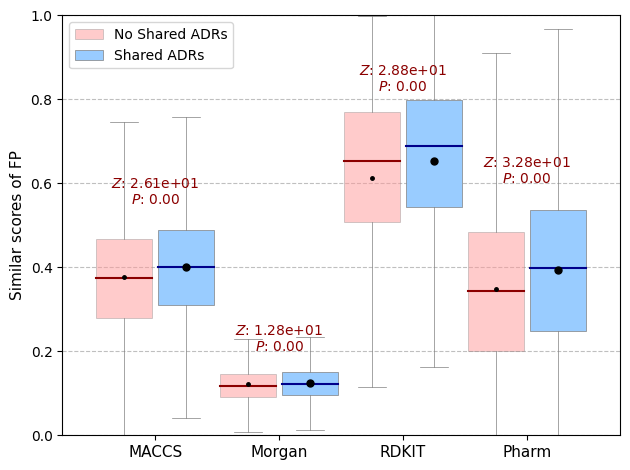

In [81]:
box_0 = plt.boxplot(drug_adr_all[drug_adr_all['group_ny'] == 0][score_list], positions= [0,1,2,3],patch_artist=True,showmeans=True, showfliers=False,
                    boxprops={"facecolor": "#ff9999", "edgecolor": "grey", "linewidth": 0.5, 'alpha': 0.5},
                    medianprops={"color": "darkred", "linewidth": 1.5},
                    meanprops={'marker': '.', 'markerfacecolor': 'black', 'markeredgecolor': 'black', 'markersize': 5},
                    whiskerprops={'color': 'grey', 'linewidth': 0.5},
                    capprops={'color': 'grey', 'linewidth': 0.5},
                    flierprops={'marker': 'o', 'color': 'red', 'alpha': 0.5})
box_1 = plt.boxplot(drug_adr_all[drug_adr_all['group_ny'] == 1][score_list], positions= [0.5,1.5,2.5,3.5],patch_artist=True,showmeans=True,showfliers=False,
                    boxprops={"facecolor": "#99ccff", "edgecolor": "grey", "linewidth": 0.5},
                    medianprops={"color": "darkblue", "linewidth": 1.5},
                    meanprops={'marker': 'o', 'markerfacecolor': 'black', 'markeredgecolor': 'black', 'markersize': 5},
                    whiskerprops={'color': 'grey', 'linewidth': 0.5},
                    capprops={'color': 'grey', 'linewidth': 0.5},
                    flierprops={'marker': '.', 'color': 'blue', 'alpha': 0.5})

plt.xticks([0.25,1.25,2.25,3.25],['MACCS', 'Morgan', 'RDKIT', 'Pharm'],fontsize=11)
plt.ylim(0,1)
plt.ylabel('Similar scores of FP',fontsize=11)
plt.grid(axis='y',ls='--',alpha=0.8)

score_list = ["drug_pair_similar_score_macc",	"drug_pair_similar_score_Morgan",	"drug_pair_similar_score_Rtoplo",	"drug_pair_similar_score_pharmfp"]
x = [0.25,1.25,2.25,3.25]
y = [0.55, 0.20, 0.82, 0.60]
for i,score in enumerate(score_list):
    t_statistic, p_value = ttest_ind(drug_adr_all[drug_adr_all['group_ny'] == 1][score],
                                  drug_adr_all[drug_adr_all['group_ny'] == 0][score],
                                  equal_var=True)  # 假设方差相等
    plt.text(x[i], y[i], f"$\mathit{{Z}}$: {t_statistic:.2e}\n$\mathit{{P}}$: {p_value:.2f}", 
            horizontalalignment='center', color='darkred', fontsize=10)


# 给箱体添加图例，每类箱线图中取第一个颜色块用于代表图例
plt.legend(handles=[box_0['boxes'][0],box_1['boxes'][0]],labels=['No Shared ADRs','Shared ADRs'])

plt.tight_layout()
plt.savefig('./result/图/figure2_box.pdf',dpi=600)
plt.show()

In [121]:
import scipy.stats


print(scipy.stats.pearsonr(drug_adr_all.com_number, drug_adr_all.drug_pair_similar_score_macc))

print(scipy.stats.spearmanr(drug_adr_all.com_number, drug_adr_all.drug_pair_similar_score_pharmfp))


(0.030882259205313956, 3.7745109597826043e-59)
SpearmanrResult(correlation=0.0725042605003215, pvalue=0.0)


In [118]:
# 计算每个分组的均值
grouped_means = drug_adr_all.groupby('com_number')['drug_pair_similar_score_macc'].mean().sort_index()
grouped_means.shape

(250,)

In [71]:
#某一个药物的相似性分布
_drug_name = drug_all.GenericName.iloc[45]
drug_one_similar = drug_adr_all[drug_adr_all['GenericName1']== _drug_name]
drug_one_similar.head(2)

,GenericName1,GenericName2,com_number,group_ny,drug_pair_similar_score_macc,drug_pair_similar_score_Morgan,drug_pair_similar_score_Rtoplo,drug_pair_similar_score_pharmfp
32400,melphalan,penciclovir,6,1,0.459459,0.175676,0.604023,0.503979
32401,melphalan,clobetasol,0,0,0.338235,0.127660,0.620797,0.285282


In [169]:
drug_all.shape

(743, 8)

In [167]:
data5['FrequencyRatingValue'].mean()

3.523241631657406

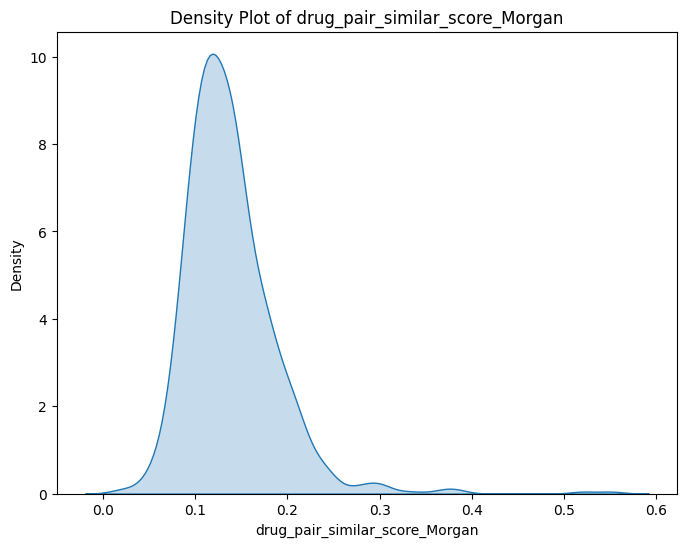

In [164]:
# 绘制密度分布图
variable = drug_one_similar.columns[5]
plt.figure(figsize=(8, 6))
sns.kdeplot(data=drug_one_similar[variable], fill=True)
plt.title(f'Density Plot of {variable}')
plt.xlabel(variable)
plt.ylabel('Density')
plt.show()

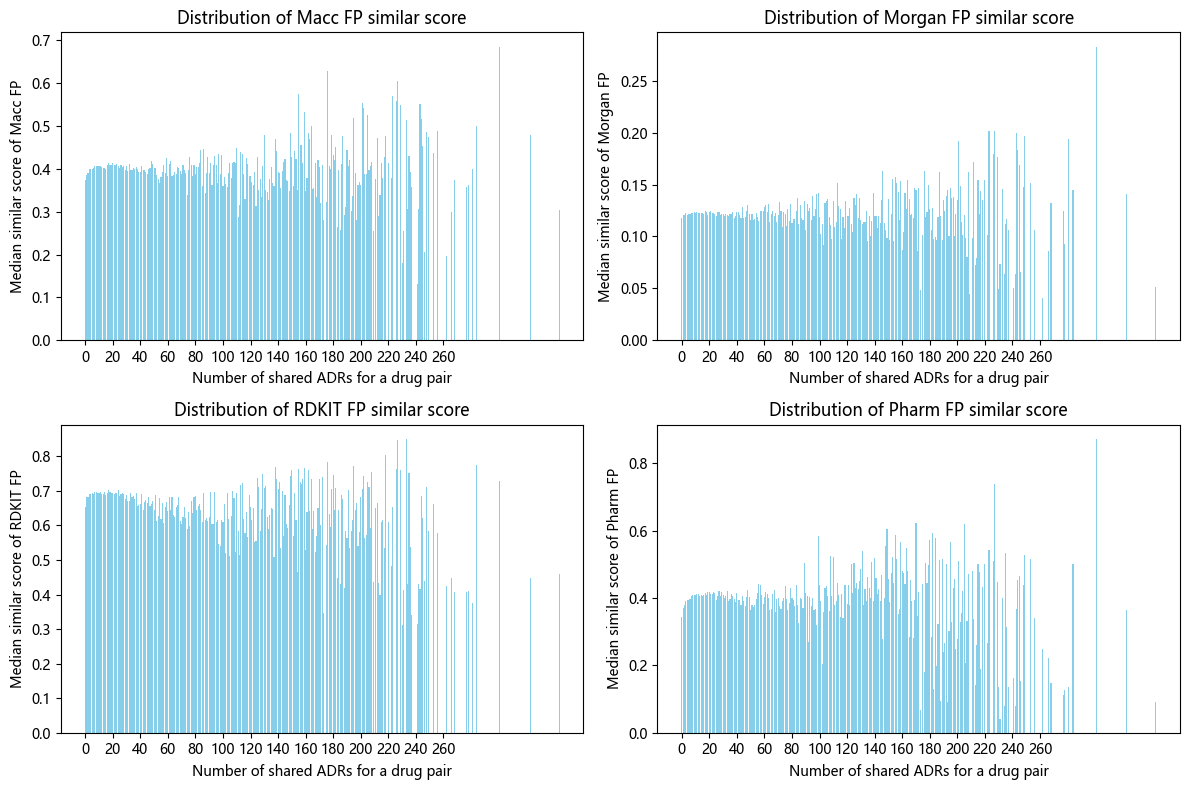

In [208]:
#中位数
# 遍历连续变量列表
continuous_variables = ['drug_pair_similar_score_macc', 'drug_pair_similar_score_Morgan', 'drug_pair_similar_score_Rtoplo', 'drug_pair_similar_score_pharmfp']
label = ['Macc','Morgan','RDKIT','Pharm']
# 初始化标签索引
labe_index = 0

plt.figure(figsize=(12, 8))
for i, continuous_var in enumerate(continuous_variables, 1):
    grouped_means = drug_adr_all.groupby('com_number')[continuous_var].median().sort_index()
    plt.subplot(2, 2, i)
    plt.bar(grouped_means.index, grouped_means, color='skyblue')  # 使用bar函数绘制条形图并指定颜色
    plt.title(f'Distribution of {label[labe_index]} FP similar score')
    plt.xlabel('Number of shared ADRs for a drug pair')
    plt.ylabel(f"Median similar score of {label[labe_index]} FP")
    plt.xticks(rotation=0)
    plt.xticks(ticks=range(min(drug_adr_all['com_number']), 260 + 1, 20))
    labe_index += 1

plt.tight_layout()
plt.savefig("./result/图/figure2_median.pdf", format="pdf", bbox_inches="tight", dpi=600)
plt.show()

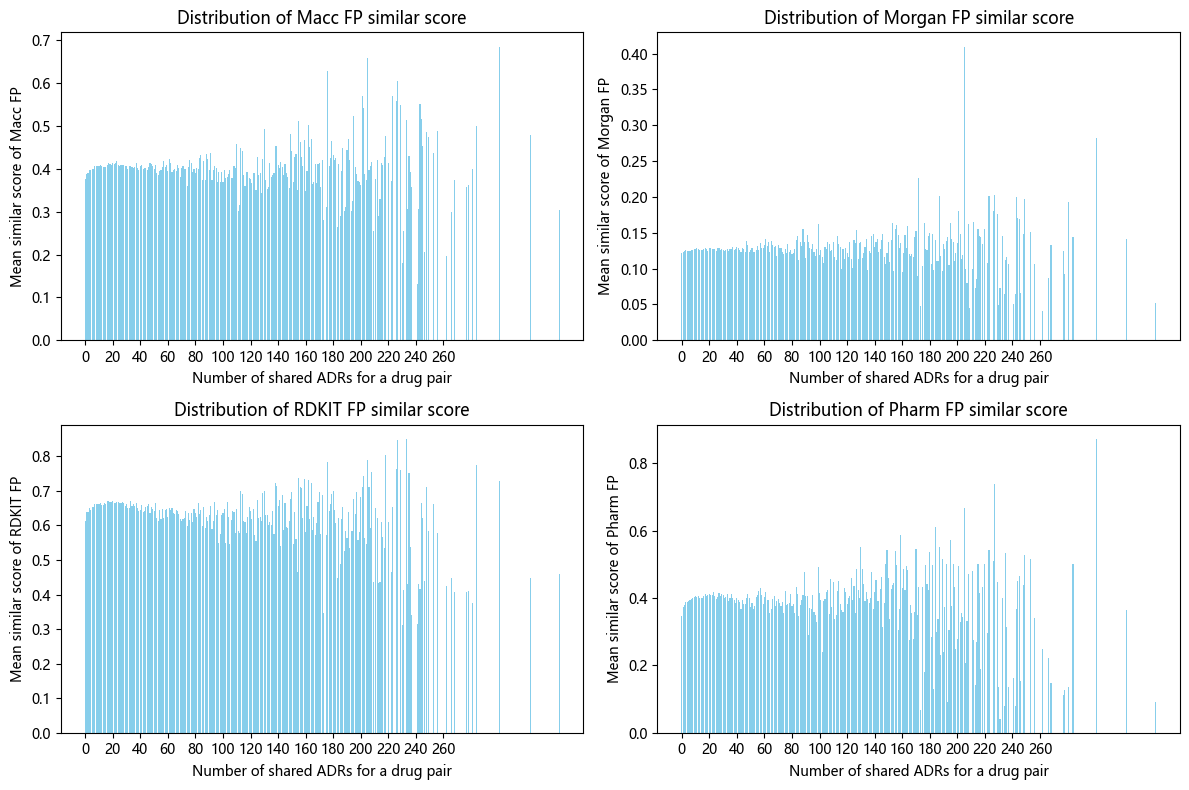

In [210]:
#中位数
# 遍历连续变量列表
continuous_variables = ['drug_pair_similar_score_macc', 'drug_pair_similar_score_Morgan', 'drug_pair_similar_score_Rtoplo', 'drug_pair_similar_score_pharmfp']
label = ['Macc','Morgan','RDKIT','Pharm']
# 初始化标签索引
labe_index = 0

plt.figure(figsize=(12, 8))
for i, continuous_var in enumerate(continuous_variables, 1):
    grouped_means = drug_adr_all.groupby('com_number')[continuous_var].mean().sort_index()
    plt.subplot(2, 2, i)
    plt.bar(grouped_means.index, grouped_means, color='skyblue')  # 使用bar函数绘制条形图并指定颜色
    plt.title(f'Distribution of {label[labe_index]} FP similar score')
    plt.xlabel('Number of shared ADRs for a drug pair')
    plt.ylabel(f"Mean similar score of {label[labe_index]} FP")
    plt.xticks(rotation=0)
    plt.xticks(ticks=range(min(drug_adr_all['com_number']), 260 + 1, 20))
    labe_index += 1

plt.tight_layout()
plt.savefig("./result/图/figure2_mean.pdf", format="pdf", bbox_inches="tight", dpi=600)
plt.show()

In [172]:
drug_adr_all.head(2)

,GenericName1,GenericName2,com_number,drug_pair_similar_score_macc,drug_pair_similar_score_pubchem,drug_pair_similar_score_Morgan,drug_pair_similar_score_Rtoplo
0,alfentanil,telithromycin,3,0.702381,0.497738,0.153333,0.857283
1,alfentanil,simeprevir,3,0.592233,0.414729,0.130137,0.852539


In [174]:
drug_adr_all.columns

Index(['GenericName1', 'GenericName2', 'com_number',
       'drug_pair_similar_score_macc', 'drug_pair_similar_score_pubchem',
       'drug_pair_similar_score_Morgan', 'drug_pair_similar_score_Rtoplo'],
      dtype='object')

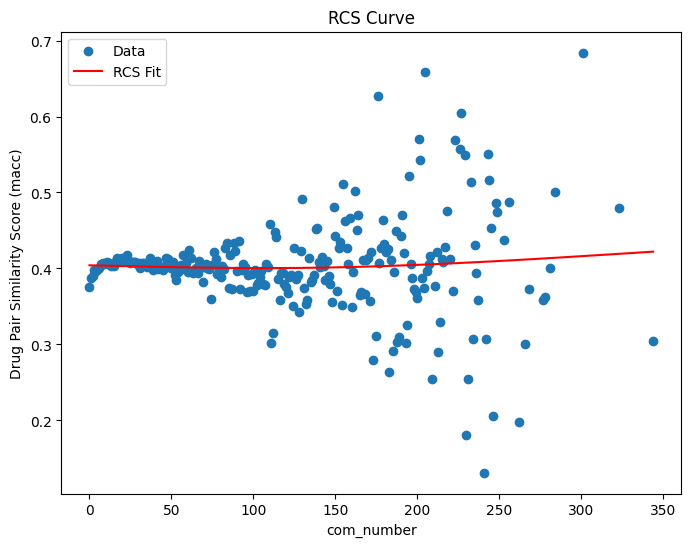

In [193]:
# 计算RCS曲线
def fit_rcs(x, y, knots=3):
    transformed_x = dmatrix(f'cr(x, df={knots})', {'x': x}, return_type='dataframe')
    model = sm.GLM(y.reset_index(drop=True), transformed_x, family=sm.families.Gaussian()).fit()
    return transformed_x, model

# 绘制RCS曲线
def plot_rcs(x, y, knots=3):
    transformed_x, model = fit_rcs(x, y, knots)
    predictions = model.predict(transformed_x)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, label='Data')
    plt.plot(np.sort(x), predictions[np.argsort(x)], color='red', label='RCS Fit')
    plt.title('RCS Curve')
    plt.xlabel('com_number')
    plt.ylabel('Drug Pair Similarity Score (macc)')
    plt.legend()
    plt.show()

# 提取变量
_rcs_data = drug_adr_all.groupby('com_number').mean()
x = _rcs_data.index
y = _rcs_data.iloc[:,0]

# 绘制RCS曲线
plot_rcs(x, y)

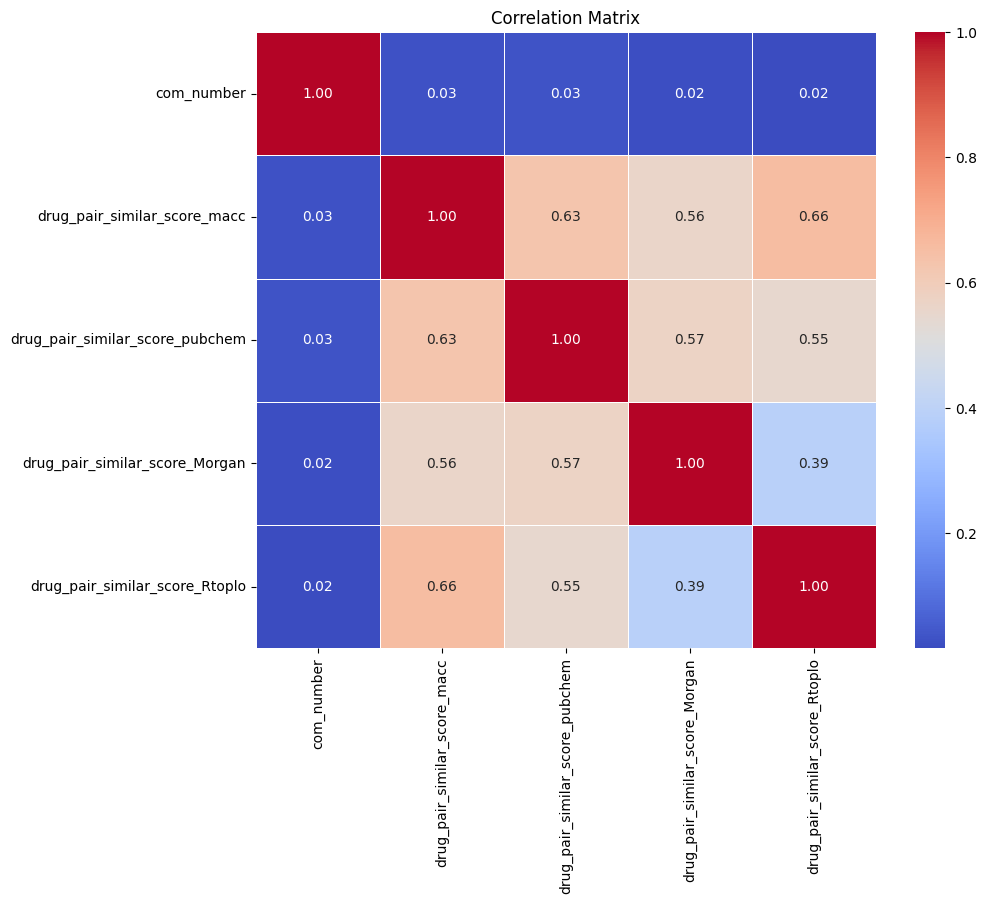

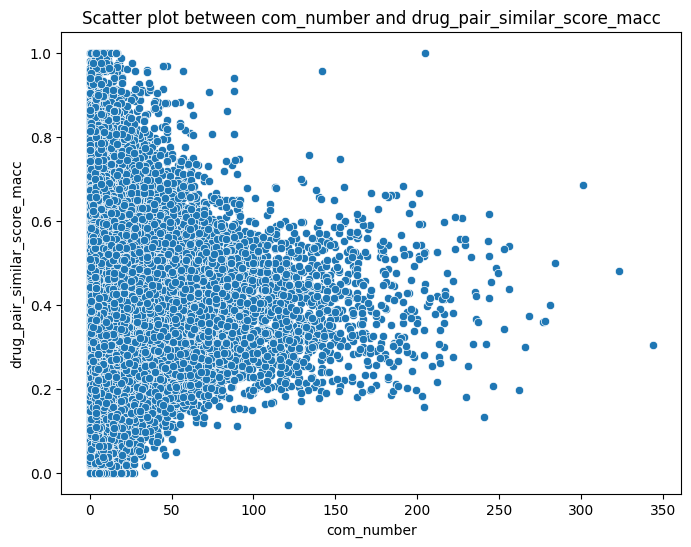

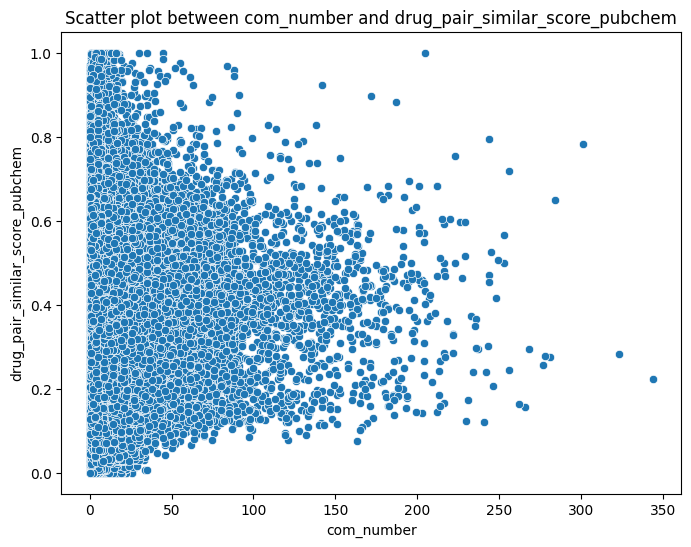

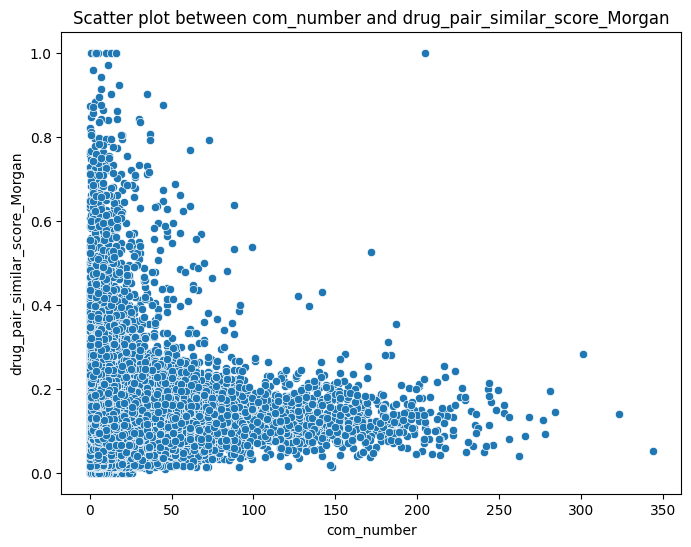

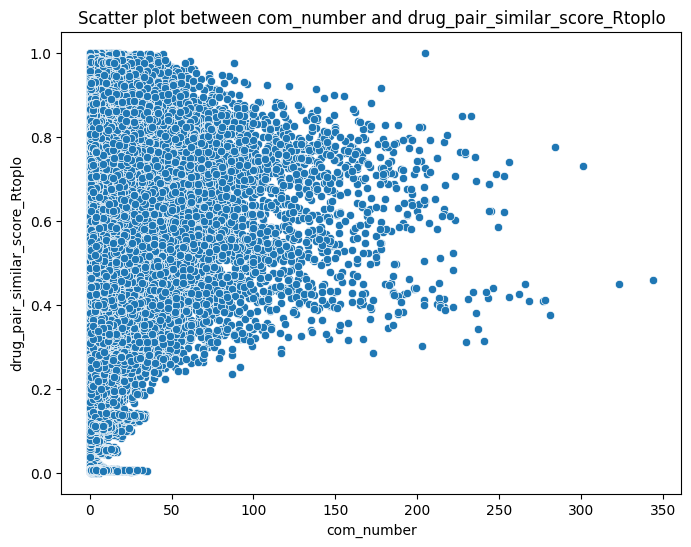

In [175]:
# 计算相关性
corr_data = drug_adr_all.iloc[:,2:]
correlation = corr_data.corr()

# 绘制相关性矩阵的热力图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

# 绘制散点图
columns = ['drug_pair_similar_score_macc', 'drug_pair_similar_score_pubchem', 'drug_pair_similar_score_Morgan', 'drug_pair_similar_score_Rtoplo']
for col in columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='com_number', y=col, data=corr_data)
    plt.title(f'Scatter plot between com_number and {col}')
    plt.xlabel('com_number')
    plt.ylabel(col)
    plt.show()